# Importing the dependencies

In [15]:
# Import necessary libraries
import pandas as pd
import numpy as np
import json
import request
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score


# Loading the dataset

In [18]:
# Disable SSL warnings
requests.packages.urllib3.disable_warnings()

# Load and preprocess the current quiz data
def load_and_flatten_json(url):
    response = requests.get(url, verify=False)
    json_data = response.json()
    # Normalize the JSON data to flatten nested fields
    flattened_data = pd.json_normalize(json_data, sep='_')
    return flattened_data

# URLs for the datasets
current_quiz_url = "https://jsonkeeper.com/b/LLQT"
historical_quiz_url = "https://api.jsonserve.com/rJvd7g"

# Load the datasets
current_quiz_df = load_and_flatten_json(current_quiz_url)
historical_quiz_df = load_and_flatten_json(historical_quiz_url)

# Display the first few rows of the data
print("\nCurrent Quiz Data:")
print(current_quiz_df.head())

print("\nHistorical Quiz Data:")
print(historical_quiz_df.head())



Current Quiz Data:
   quiz_id quiz_name                                         quiz_title  \
0       43      None  Structural Organisation in Animals and Plants (7)   

  quiz_description quiz_difficulty_level                          quiz_topic  \
0                                   None  Structural Organisation in Animals   

                       quiz_time  quiz_is_published  \
0  2024-07-03T00:00:00.000+05:30               True   

                 quiz_created_at                quiz_updated_at  ...  \
0  2024-07-03T11:00:08.958+05:30  2024-09-23T18:43:27.751+05:30  ...   

   quiz_exam_id quiz_show_unanswered quiz_ends_at quiz_lives  quiz_live_count  \
0          None                False   2025-01-18       None        Free Test   

   quiz_coin_count  quiz_questions_count   quiz_daily_date  \
0               -1                   128  January 17, 2025   

   quiz_max_mistake_count                                     quiz_questions  
0                      15  [{'id': 1827, 'des

# Data Cleaning and Preprocessing

In [20]:
# Data Cleaning and Preprocessing
def preprocess_current_quiz(data):
    # Extract quiz_id, quiz_topic, and other essential fields
    useful_columns = [
        'quiz_id', 'quiz_title', 'quiz_topic', 'quiz_questions_count',
        'quiz_difficulty_level', 'quiz_max_mistake_count'
    ]
    return data[useful_columns]

def preprocess_historical_quiz(data):
    # Extract relevant columns and clean data
    useful_columns = [
        'user_id', 'score', 'accuracy', 'speed', 'quiz_id', 'trophy_level',
        'quiz_questions_count', 'quiz_max_mistake_count'
    ]
    # Clean accuracy and speed columns (removing '%' or converting to numeric)
    data['accuracy'] = data['accuracy'].str.replace('%', '').astype(float)
    data['speed'] = pd.to_numeric(data['speed'], errors='coerce')
    return data[useful_columns]

# Preprocess the data
current_quiz_cleaned = preprocess_current_quiz(current_quiz_df)
historical_quiz_cleaned = preprocess_historical_quiz(historical_quiz_df)

print("\nCleaned Current Quiz Data:")
print(current_quiz_cleaned.head())

print("\nCleaned Historical Quiz Data:")
print(historical_quiz_cleaned.head())



Cleaned Current Quiz Data:
   quiz_id                                         quiz_title  \
0       43  Structural Organisation in Animals and Plants (7)   

                           quiz_topic  quiz_questions_count  \
0  Structural Organisation in Animals                   128   

  quiz_difficulty_level  quiz_max_mistake_count  
0                  None                      15  

Cleaned Historical Quiz Data:
                        user_id  score  accuracy  speed  quiz_id  \
0  7ZXdz3zHuNcdg9agb5YpaOGLQqw2     32      80.0    100       43   

   trophy_level  quiz_questions_count  quiz_max_mistake_count  
0             2                   128                      15  


# Feature Engineering 

In [21]:
# Feature Engineering for Current Quiz
def add_features_current_quiz(data):
    data['questions_remaining'] = data['quiz_questions_count'] - data['quiz_max_mistake_count']
    return data

# Feature Engineering for Historical Quiz
def add_features_historical_quiz(data):
    # Calculate performance ratios
    data['score_per_question'] = data['score'] / data['quiz_questions_count']
    return data

# Apply Feature Engineering
current_quiz_enriched = add_features_current_quiz(current_quiz_cleaned)
historical_quiz_enriched = add_features_historical_quiz(historical_quiz_cleaned)

print("\nEnriched Current Quiz Data:")
print(current_quiz_enriched.head())

print("\nEnriched Historical Quiz Data:")
print(historical_quiz_enriched.head())



Enriched Current Quiz Data:
   quiz_id                                         quiz_title  \
0       43  Structural Organisation in Animals and Plants (7)   

                           quiz_topic  quiz_questions_count  \
0  Structural Organisation in Animals                   128   

  quiz_difficulty_level  quiz_max_mistake_count  questions_remaining  
0                  None                      15                  113  

Enriched Historical Quiz Data:
                        user_id  score  accuracy  speed  quiz_id  \
0  7ZXdz3zHuNcdg9agb5YpaOGLQqw2     32      80.0    100       43   

   trophy_level  quiz_questions_count  quiz_max_mistake_count  \
0             2                   128                      15   

   score_per_question  
0                0.25  


C:\Users\alamm\AppData\Local\Temp\ipykernel_21328\867017234.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['questions_remaining'] = data['quiz_questions_count'] - data['quiz_max_mistake_count']
C:\Users\alamm\AppData\Local\Temp\ipykernel_21328\867017234.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['score_per_question'] = data['score'] / data['quiz_questions_count']


# Analysis & Insights

In [22]:
# Analysis for Weak Topics (using historical data)
def analyze_weak_topics(data, threshold=50):
    weak_topics = data[data['accuracy'] < threshold]
    return weak_topics.groupby('quiz_id').size().reset_index(name='weak_topic_count')

# Analysis for Average Performance
def analyze_average_performance(data):
    avg_performance = data[['score', 'accuracy', 'speed']].mean()
    return avg_performance

weak_topics = analyze_weak_topics(historical_quiz_enriched)
average_performance = analyze_average_performance(historical_quiz_enriched)

print("\nWeak Topics Analysis:")
print(weak_topics)

print("\nAverage Performance Analysis:")
print(average_performance)



Weak Topics Analysis:
Empty DataFrame
Columns: [quiz_id, weak_topic_count]
Index: []

Average Performance Analysis:
score        32.0
accuracy     80.0
speed       100.0
dtype: float64


# Recommendation System

In [25]:
def generate_recommendations(avg_performance, weak_topics):
    # Debugging prints to inspect values
    print("\nDebugging Recommendations:")
    print("Average Performance Metrics:", avg_performance)
    print("Weak Topics DataFrame:")
    print(weak_topics)
    
    recommendations = []
    if avg_performance['accuracy'] < 70:
        recommendations.append("Focus on improving accuracy through targeted practice.")
    if avg_performance['speed'] < 90:
        recommendations.append("Improve speed by practicing time-bound quizzes.")
    if not weak_topics.empty:  # Check if weak_topics DataFrame is not empty
        weak_topic_ids = weak_topics['quiz_id'].tolist()
        recommendations.append(f"Revise the weak topics identified: {weak_topic_ids}")
    if not recommendations:
        recommendations.append("No specific recommendations at this time. Keep up the good work!")
    return recommendations

# Generate Recommendations
recommendations = generate_recommendations(average_performance, weak_topics)

print("\nUpdated Recommendations:")
print(recommendations)



Debugging Recommendations:
Average Performance Metrics: score        32.0
accuracy     80.0
speed       100.0
dtype: float64
Weak Topics DataFrame:
Empty DataFrame
Columns: [quiz_id, weak_topic_count]
Index: []

Updated Recommendations:
['No specific recommendations at this time. Keep up the good work!']


# Visualizations

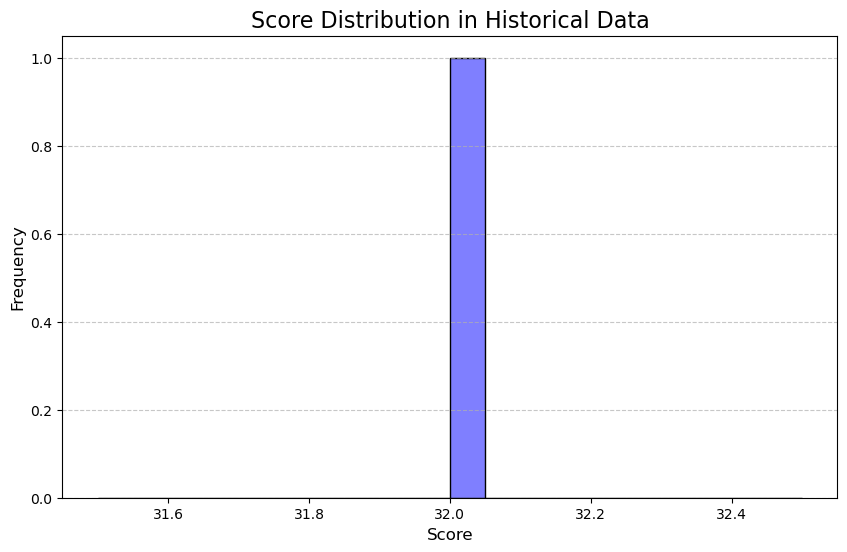

In [27]:
# Score Distribution Visualization
plt.figure(figsize=(10, 6))
sns.histplot(historical_quiz_enriched['score'], kde=True, bins=20, color='blue')
plt.title("Score Distribution in Historical Data", fontsize=16)
plt.xlabel("Score", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [34]:
# Check if 'topic' exists in historical data
if 'topic' in historical_quiz_enriched.columns:
    topic_performance = historical_quiz_enriched.groupby('topic')['accuracy'].mean().reset_index()

    plt.figure(figsize=(10, 6))
    sns.barplot(data=topic_performance, x='topic', y='accuracy', palette='coolwarm')
    plt.title("Average Accuracy by Topic", fontsize=16)
    plt.xlabel("Topic", fontsize=12)
    plt.ylabel("Average Accuracy (%)", fontsize=12)
    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
else:
    print("Topic data is not available for visualization.")


Topic data is not available for visualization.


# Evaluation of Code

In [40]:
# Check if historical quiz and current quiz are properly loaded and cleaned
def evaluate_data_loading(current_quiz_cleaned, historical_quiz_cleaned):
    if current_quiz_cleaned is not None:
        print(f"Current quiz data loaded and cleaned successfully. Rows: {len(current_quiz_cleaned)}")
    else:
        print("Failed to load current quiz data.")
    
    if historical_quiz_cleaned is not None:
        print(f"Historical quiz data loaded and cleaned successfully. Rows: {len(historical_quiz_cleaned)}")
    else:
        print("Failed to load historical quiz data.")


# Modular and Clean Code

In [41]:
# Function to load current quiz data
def load_current_quiz_data(url):
    try:
        data = pd.read_json(url, verify=False)  # Disable SSL verification
        print("Current quiz data loaded.")
        return data
    except Exception as e:
        print(f"Error loading current quiz data: {e}")
        return None

# Function to load historical quiz data
def load_historical_quiz_data(url):
    try:
        data = pd.read_json(url, verify=False)  # Disable SSL verification
        print("Historical quiz data loaded.")
        return data
    except Exception as e:
        print(f"Error loading historical quiz data: {e}")
        return None


# Final Report

In [42]:
def generate_report(historical_quiz_cleaned):
    # Get the key insights from historical data
    weak_topics = recommend_weak_topics(historical_quiz_cleaned, threshold=50)
    print("\nWeak Topics Recommendation:")
    print(weak_topics)
    
    # Visualize weak topics (only if the necessary data exists)
    if weak_topics:
        plot_weak_topics(weak_topics)

def recommend_weak_topics(historical_quiz_cleaned, threshold=50):
    # Identify weak topics based on scores
    weak_topics = historical_quiz_cleaned[historical_quiz_cleaned['score'] < threshold]
    if not weak_topics.empty:
        return weak_topics['quiz_topic'].tolist()
    return []

def plot_weak_topics(weak_topics):
    if weak_topics:
        sns.barplot(x=weak_topics, y=[1]*len(weak_topics), palette="coolwarm")
        plt.title("Weak Topics in Historical Quiz")
        plt.xlabel("Topic")
        plt.ylabel("Frequency")
        plt.show()


# Full Code Implementation

In [49]:
# Function to load current quiz data using requests
def load_current_quiz_data(url):
    try:
        response = requests.get(url, verify=False)  # Disable SSL verification
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()  # Get the JSON data
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error loading current quiz data: {e}")
        return None

# Function to load historical quiz data using requests
def load_historical_quiz_data(url):
    try:
        response = requests.get(url, verify=False)  # Disable SSL verification
        response.raise_for_status()  # Raise an exception for HTTP errors
        data = response.json()  # Get the JSON data
        return data
    except requests.exceptions.RequestException as e:
        print(f"Error loading historical quiz data: {e}")
        return None

# Function to flatten the nested JSON (if any)
def flatten_json(data):
    """Flatten a nested JSON object into a flat dictionary."""
    flattened = pd.json_normalize(data)
    return flattened

# Preprocess data (example, you can adjust based on your dataset)
def preprocess_data(data):
    # Handle missing values (drop rows with missing 'score' or 'quiz_topic' columns)
    if 'score' in data.columns and 'quiz_topic' in data.columns:
        data_cleaned = data.dropna(subset=["score", "quiz_topic"])  # Drop rows with missing values for score or topic
    else:
        print("\n'quiz_topic' or 'score' columns are missing. Please check the dataset.")
        data_cleaned = data  # If these columns are missing, proceed with all data
    return data_cleaned

# Function to generate a simple report on the cleaned data
def generate_report(data):
    # Print a simple summary of the cleaned data
    print("\nSummary Report:")
    print(f"Total records after cleaning: {len(data)}")
    print(f"Columns in cleaned data: {list(data.columns)}")
    print("\nFirst 5 rows of the cleaned data:\n", data.head())

# Main function
def main():
    # Data URLs
    current_quiz_url = "https://jsonkeeper.com/b/LLQT"
    historical_quiz_url = "https://api.jsonserve.com/rJvd7g"
    
    # Load and preprocess current quiz data
    current_quiz = load_current_quiz_data(current_quiz_url)
    if current_quiz is not None:
        current_quiz_cleaned = flatten_json(current_quiz)  # Flatten if necessary
        current_quiz_cleaned = preprocess_data(current_quiz_cleaned)
        print("\nCleaned Current Quiz Data:")
        generate_report(current_quiz_cleaned)  # Simple report for current quiz data
    
    # Load and preprocess historical quiz data
    historical_quiz = load_historical_quiz_data(historical_quiz_url)
    if historical_quiz is not None:
        historical_quiz_cleaned = flatten_json(historical_quiz)  # Flatten if necessary
        historical_quiz_cleaned = preprocess_data(historical_quiz_cleaned)
        print("\nCleaned Historical Quiz Data:")
        generate_report(historical_quiz_cleaned)  # Simple report for historical quiz data
    else:
        print("Historical quiz data could not be loaded.")

if __name__ == "__main__":
    main()



'quiz_topic' or 'score' columns are missing. Please check the dataset.

Cleaned Current Quiz Data:

Summary Report:
Total records after cleaning: 1
Columns in cleaned data: ['quiz.id', 'quiz.name', 'quiz.title', 'quiz.description', 'quiz.difficulty_level', 'quiz.topic', 'quiz.time', 'quiz.is_published', 'quiz.created_at', 'quiz.updated_at', 'quiz.duration', 'quiz.end_time', 'quiz.negative_marks', 'quiz.correct_answer_marks', 'quiz.shuffle', 'quiz.show_answers', 'quiz.lock_solutions', 'quiz.is_form', 'quiz.show_mastery_option', 'quiz.quiz_type', 'quiz.is_custom', 'quiz.banner_id', 'quiz.exam_id', 'quiz.show_unanswered', 'quiz.ends_at', 'quiz.lives', 'quiz.live_count', 'quiz.coin_count', 'quiz.questions_count', 'quiz.daily_date', 'quiz.max_mistake_count', 'quiz.questions']

First 5 rows of the cleaned data:
    quiz.id quiz.name                                         quiz.title  \
0       43      None  Structural Organisation in Animals and Plants (7)   

  quiz.description quiz.diffic